<br/><br/><div id="top"></div>

<center><a style="font-size: 40pt; font-weight: bold">Rotten Tomato Movie Review</a></center>
<br/>
<center><a style="font-size: 22pt; font-weight: bold">Binary Classification on Artificial Movie Data Set</a></center>
<br/>

---

# Group members



* HACHEM Racha
* FESTA Denis
* BHATT Ragi


# Introduction

## Problem Statement

Given a dataset of movie reviews from Rotten Tomatoes, the objective is to perform sentiment analysis and classify each review into one of the following categories: rotten or fresh. The sentiment classification is based on the text of the review that is classified into one of the following categories: positive, negative, or neutral as well as the type of critic (Top Critics or All Critics).

The goal of this sentiment analysis is to provide insights into the overall sentiment of the movie reviews, identify the most positive and negative movies, and potentially improve the quality of movies by analyzing the feedback provided by the reviewers.

## Approach

To achieve this objective, we need to preprocess the text data, extract features, train a sentiment classification model using machine learning techniques, and evaluate the performance of the model. Additionally, we may need to explore the dataset to identify potential issues such as class imbalance or missing data and address them accordingly. Finally, we can visualize the results of the sentiment analysis to gain insights into the sentiment of the movie reviews and potentially make recommendations to improve the quality of the movies.

## Data

The website "Rotten Tomatoes" allows to compare the ratings given by regular users (audience score) and the ratings given/reviews provided by critics (tomatometer) who are certified members of various writing guilds or film critic-associations.

We have two datasets, namely critics dataset and movies dataset.

In the movies dataset each record represents a movie available on Rotten Tomatoes, with the URL used for the scraping, movie tile, description, genres, duration, director, actors, users' ratings, and critics' ratings.

In the critics dataset each record represents a critic review published on Rotten Tomatoes, with the URL used for the scraping, critic name, review publication, date, score, and content.

Link to Dataset: https://www.kaggle.com/datasets/stefanoleone992/rotten-tomatoes-movies-and-critic-reviews-dataset


In [ ]:
!pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 KB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=4db0094924e0fda5b5e3f2648cade6dad124626d65def6a593fe1fed3895dc9b
  Stored in directory: /root/.cache/pip/wheels/13/c7/b0/79f66658626032e78fc1a83103690ef6797d551cb22e56e734
Successfully built langdetect


In [ ]:
from datetime import datetime
from pathlib import Path

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset, DataLoader, random_split


import langdetect
import random
import nltk
import gensim
import torch
import torch.nn as nn

import imblearn
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import gc
import tqdm
import re
from collections import defaultdict
import string
from textblob import TextBlob


In [ ]:
%reload_ext autoreload
%autoreload 2

# Set precision for pd and np (np: suppress also sci notation)
np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = "{:,.4g}".format

print(sklearn.__version__)  # Version tested on sklearn.__version__ == 1.1.3

1.2.1


# Data Loading

In [ ]:
!wget "https://docs.google.com/uc?export=download&id=1LR3NJYGoA_yRbN8iX_DgZrUibwNAJFma&confirm=T" -O "rotten_tomatoes_critic_reviews.csv"
!wget "https://docs.google.com/uc?export=download&id=1QL3O-ZATclLKi2y44kRkaRwVB1oA_CPe&confirm=T" -O "rotten_tomatoes_movies.csv"

--2023-03-06 23:26:20--  https://docs.google.com/uc?export=download&id=1LR3NJYGoA_yRbN8iX_DgZrUibwNAJFma&confirm=T
Resolving docs.google.com (docs.google.com)... 173.194.194.139, 173.194.194.102, 173.194.194.113, ...
Connecting to docs.google.com (docs.google.com)|173.194.194.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-as-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/omovh4v8nskvno2a69d434cdf8s7m0n9/1678145175000/17437101782846932946/*/1LR3NJYGoA_yRbN8iX_DgZrUibwNAJFma?e=download&uuid=5a2719fa-4027-41e2-a779-c797cd627e82 [following]
--2023-03-06 23:26:20--  https://doc-14-as-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/omovh4v8nskvno2a69d434cdf8s7m0n9/1678145175000/17437101782846932946/*/1LR3NJYGoA_yRbN8iX_DgZrUibwNAJFma?e=download&uuid=5a2719fa-4027-41e2-a779-c797cd627e82
Resolving doc-14-as-docs.googleusercontent.com (doc-14-as-docs.googleusercontent.com)... 142.250.136.

In [ ]:
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download("omw-1.4")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
critic_df = pd.read_csv('rotten_tomatoes_critic_reviews.csv')

In [ ]:
critic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1130017 entries, 0 to 1130016
Data columns (total 8 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   rotten_tomatoes_link  1130017 non-null  object
 1   critic_name           1111488 non-null  object
 2   top_critic            1130017 non-null  bool  
 3   publisher_name        1130017 non-null  object
 4   review_type           1130017 non-null  object
 5   review_score          824081 non-null   object
 6   review_date           1130017 non-null  object
 7   review_content        1064211 non-null  object
dtypes: bool(1), object(7)
memory usage: 61.4+ MB


In [ ]:
movie_df = pd.read_csv('rotten_tomatoes_movies.csv')

In [ ]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17712 entries, 0 to 17711
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   rotten_tomatoes_link              17712 non-null  object 
 1   movie_title                       17712 non-null  object 
 2   movie_info                        17391 non-null  object 
 3   critics_consensus                 9134 non-null   object 
 4   content_rating                    17712 non-null  object 
 5   genres                            17693 non-null  object 
 6   directors                         17518 non-null  object 
 7   authors                           16170 non-null  object 
 8   actors                            17360 non-null  object 
 9   original_release_date             16546 non-null  object 
 10  streaming_release_date            17328 non-null  object 
 11  runtime                           17398 non-null  float64
 12  prod

In [ ]:
movie_df.head()

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,...,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,...,20th Century Fox,Rotten,49,149,Spilled,53,2.544e+05,43,73,76
1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,...,Sony Pictures Classics,Certified-Fresh,87,142,Upright,64,1.157e+04,44,123,19
2,m/10,10,"A successful, middle-aged Hollywood songwriter...",Blake Edwards' bawdy comedy may not score a pe...,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,...,Waner Bros.,Fresh,67,24,Spilled,53,1.468e+04,2,16,8
3,m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),Following the closing arguments in a murder tr...,Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,...,Criterion Collection,Certified-Fresh,100,54,Upright,97,1.054e+05,6,54,0
4,m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea","In 1866, Professor Pierre M. Aronnax (Paul Luk...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,...,Disney,Fresh,89,27,Upright,74,6.892e+04,5,24,3


In [ ]:
critic_df.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...


In [ ]:
critic_df.describe()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
count,1130017,1111488,1130017,1130017,1130017,824081,1130017,1064211
unique,17712,11108,2,2230,2,814,8015,949181
top,m/star_wars_the_rise_of_skywalker,Emanuel Levy,False,New York Times,Fresh,3/5,2000-01-01,Parental Content Review
freq,992,8173,841481,13293,720210,90273,48019,267


In [ ]:
critic_df.dtypes.value_counts()

object    7
bool      1
dtype: int64

# Exploratory Analysis

In [ ]:
# How many reviews are there?
print("Number of reviews:", len(critic_df))

Number of reviews: 1130017


In [ ]:
# In the critic reviews, we are interested in the review type (fresh or rotten), the review score and the review content.
reviews_df = critic_df[["review_type", "review_score", "review_content"]]
display(reviews_df.head())

,review_type,review_score,review_content
0,Fresh,NaN,A fantasy adventure that fuses Greek mythology...
1,Fresh,NaN,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,Fresh,NaN,With a top-notch cast and dazzling special eff...
3,Fresh,3.5/5,Whether audiences will get behind The Lightnin...
4,Rotten,NaN,What's really lacking in The Lightning Thief i...


Target Distribution

Review type counts:


Fresh     720210
Rotten    409807
Name: review_type, dtype: int64

Review type percents:


Fresh    0.6373
Rotten   0.3627
Name: review_type, dtype: float64

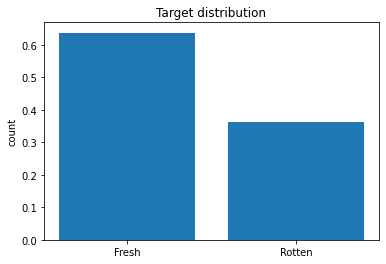

In [ ]:
# Let's focus on the review type first.
# We want to know how many reviews are fresh and how many are rotten.
# We can use the value_counts() method to get the counts for each value in the review_type column.

review_type_counts = reviews_df["review_type"].value_counts()
print("Review type counts:")
display(review_type_counts)

# We can also use the value_counts() method to get the percentage of each value in the review_type column.
review_type_percents = reviews_df["review_type"].value_counts(normalize=True)
print("Review type percents:")
display(review_type_percents)

plt.bar(x=['Fresh', 'Rotten'], height=reviews_df["review_type"].value_counts(normalize=True).to_numpy())
plt.ylabel('count')
plt.title('Target distribution')
plt.show()

In [ ]:
# What would happen if we took into account only the reviwes with a non-null review score?
reviews_df = reviews_df[reviews_df["review_score"].notnull()]
print("Number of reviews with a non-null review score :", len(reviews_df))


Number of reviews with a non-null review score : 824081


3/5      90273
4/5      83659
3/4      72366
2/5      60174
2/4      47546
2.5/4    44994
3.5/4    34371
3.5/5    30885
B        24358
5/5      24139
2.5/5    21260
1/5      20709
1.5/4    20475
B+       19822
4/4      18239
Name: review_score, dtype: int64

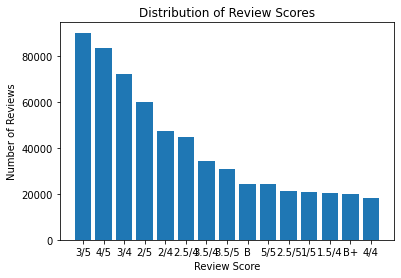

In [ ]:
# It's a good number so we can continue with this subset of the data.
# Now, it's better to work on a more balanced dataset.
# Of all the reviews, what is the distribution of the review scores?
reviews_score_counts = reviews_df["review_score"].value_counts().iloc[:15]

display(reviews_score_counts)

plt.bar(reviews_score_counts.index, reviews_score_counts.values)
plt.xlabel("Review Score")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Review Scores")
plt.show()

Number of reviews over 5: 357067
Number of reviews over 4: 258454


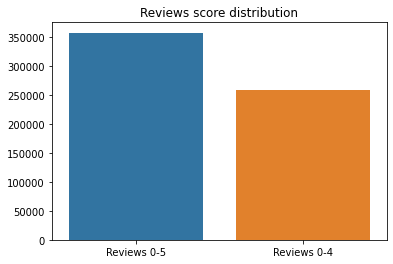

In [ ]:
# We see there's some imbalance in the way the scores are evaluated:
# some scores are with 5 as the best, some others with 4 as the best.
# What if we go back and check which one of the two types of scoring is the most common?
reviews_over_five_df = reviews_df[reviews_df["review_score"].str.endswith("/5")]
reviews_over_four_df = reviews_df[reviews_df["review_score"].str.endswith("/4")]

n_reviews_over_five = len(reviews_over_five_df)
n_reviews_over_four = len(reviews_over_four_df)
print("Number of reviews over 5:", n_reviews_over_five)
print("Number of reviews over 4:", n_reviews_over_four)

# Barchart of the reviews score distribution.
# We can see that the reviews are mostly over 5
x = ['Reviews 0-5', 'Reviews 0-4']

# Create the bar chart
sns.barplot(x=x, y=[n_reviews_over_five, n_reviews_over_four])

# Add titles and labels
plt.title('Reviews score distribution')
# plt.xlabel('Values')
# plt.ylabel('Scalar')

# Show the chart
plt.show()

# Preprocessing the Data

In summary: there are a lot of reviews in the dataset
but different strategy choices can leave the dataset almost intact or greatly
dicrease its size.
The most relevant quantities described in the dataset are:
- the content of a review
- the type of a review [rotten/fresh]
- the score of a review.

Given the task of analyzing the sentiment of a review, there are
two paths to be considered:
- ignore the score of a review and only consider the type,
- consider the score of a review when trying to predict the type.

The following section of the notebook will assume the choice of the second strategy. Soon it will become evident that the scores assigned to the review
are not a trivial case to handle. To begin with, not all the reviews have
a score, and secondly, not all the reviews are rated with the same degrees:
some of them are rated with a score from 0 to 5, others with a score
from 0 to 4, others with a score from 0 to 100. To keep things simple,
the choice made is to only consider the reviews with a score from 0 to 5 because they are greatest in quantity.

It will also show up that some reviews considered "Fresh" have a rating of 1 or 0 and some considered "Rotten" have a rating of 4 or 5. Although there might be
good reasons from the authors of the review to create such an apparent
contradiction, the strategy chosen was to train the models over a dataset
where the type of a review and its content go in parallel, as such, it was chosen to keep only the "Rotten" reviews with a score $s:\,0\leq s\leq 2.5$
and the "Fresh" reviews with a score $s:\,3\leq s\leq 5$, 
in particular, since the scores are discretized as multiples of $0.5$:
- the possible scores for a "Rotten" review are $\{0, 0.5, 1, 1.5, 2, 2.5\}$
- the possible scores for a "Fresh" review are $\{3, 3.5, 4, 4.5, 5\}$.

Notice that the cardinality of the set of possible scores for the "Rotten"
reviews is greater than the score of the "Fresh" reviews, this will lead to
two different sub-paths:
- when dealing with the prediction of the type of a review [rotten/fresh], there will be the need of
for the "Rotten" reviews to be equal in number to the "Fresh" reviews,
- when dealing with the prediction of the score of a review (regression), then
the number of reviews will need to be the same for every score.

Given the previous subdivision of the 11 possible scores among the 2 possible types, it was decided to sample $n$ reviews for every possible score and then add $n$ more reviews with one of the possible scores for a "Fresh" rotten,
in particular the choice made was to add $n$ scores to the set of reviews with a score of 3 (other approaches would have been possible, such as taking $n$ additional scores randomly to make the number of "Fresh" and "Rotten" reviews balanced again).
Given this choice of redistribution of the reviews, before tackling the regression task, to make the dataset balanced with respect to the scores (whereas previously it was made balanced with respect to the types) it was sufficient to drop $n$ reviews from the set set of reviews with a score of 3. 

After balancing the dataset, the content of the reviews was preprocessed
according to the following pipeline:
- numerical data or irrelevant characters removal
- tokenization
- stopwords removal
- lemmatization.

Next, the text obtained joining all the preprocessed reviews was embedded
and plotted (the plot is around 20 MB, this is the reason why it's not show,
but it will be made available.)

The last step is the analysis of the the distribution of the lengths of the reviews,
first with respect to the length measured in number of characters and then in number of tokens, the second one in particular is relevant to decide what size
of the input to pick when training a neural network model on top of a pre-trained BERT model.
In this case, the lenght of the reviews (already preprocessed) will always be
$\leq 30$, this fact will help improving the performance of the neural-network training.

In [ ]:
# Focusing only on the reviews scored 0-5
reviews_df = reviews_over_five_df

2/5       59541
1/5       20675
2.5/5     18482
1.5/5      8211
3/5        7411
0/5        2448
0.5/5      1456
3.5/5        98
2.25/5       80
2.75/5       54
2.3/5        48
2.4/5        45
2.8/5        40
1.75/5       36
2.2/5        30
1.25/5       26
4/5          26
2.9/5        21
1.8/5        18
1.9/5        14
5/5          13
1.7/5        11
1.3/5        10
1.4/5         9
1.2/5         7
Name: review_score, dtype: int64

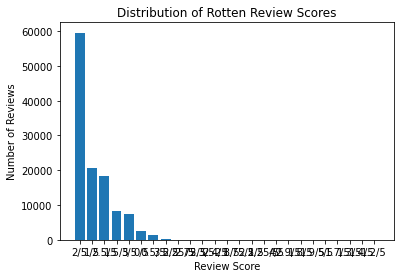

In [ ]:
# Focusing on Rotten Reviews, what is the distribution of the review scores?

rotten_reviews = reviews_df[reviews_df["review_type"] == "Rotten"]
rotten_reviews_score_counts = rotten_reviews["review_score"].value_counts().iloc[:25]
display(rotten_reviews_score_counts)

plt.bar(rotten_reviews_score_counts.index, rotten_reviews_score_counts.values)
plt.xlabel("Review Score")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Rotten Review Scores")
plt.show()

In [ ]:
# Even twenty-six reviews with a score of 4/5... weren't they supposed to be rotten???
# And it's not even the strangest thing.
# Now I'm curious, let's see the content of the review with a 4.7/5 score...

strange_review = rotten_reviews[rotten_reviews["review_score"] == "4.7/5"]
print("Strange review:")
display(strange_review)
print(strange_review.review_content.values[0])

Strange review:


,review_type,review_score,review_content
1040586,Rotten,4.7/5,Thriller at best qualifies as an interesting a...


Thriller at best qualifies as an interesting attempt at bringing additional perspectives to horror. Given the potential of this particular niche of the horror genre, that also makes it quite the wasted opportunity.


Number of rotten reviews: 110813


2/5      59541
1/5      20675
2.5/5    18482
1.5/5     8211
0/5       2448
0.5/5     1456
Name: review_score, dtype: int64

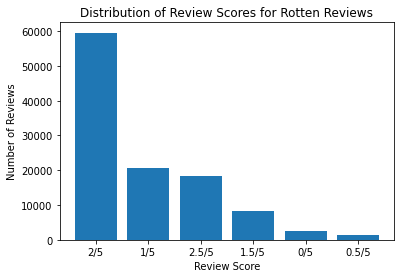

In [ ]:
# Unfortunately it's still obscure, at least to me, why this review would have a so high score...

# Anyway, it's maybe better, if we focus on the rotten reviews, to just consider those with 'rotten scores' as well.
# Maybe 0, 0.5, 1, 1.5, 2, 2.5 is a good threshold.
rotten_scores = ["0/5", "0.5/5", "1/5", "1.5/5", "2/5", "2.5/5"]
rotten_reviews = rotten_reviews[rotten_reviews["review_score"].isin(rotten_scores)]
rotten_reviews_score_counts = rotten_reviews["review_score"].value_counts()
print("Number of rotten reviews:", len(rotten_reviews))
display(rotten_reviews_score_counts)

plt.bar(rotten_reviews_score_counts.index, rotten_reviews_score_counts.values)
plt.xlabel("Review Score")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Review Scores for Rotten Reviews")
plt.show()

4/5       83633
3/5       82862
3.5/5     30787
5/5       24126
4.5/5     12381
2.5/5      2778
2/5         633
3.75/5      137
3.25/5       95
2.75/5       93
4.25/5       72
3.2/5        72
3.8/5        53
4.75/5       41
3.4/5        37
Name: review_score, dtype: int64

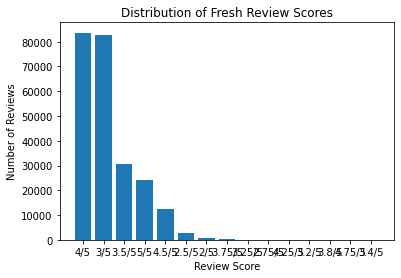

In [ ]:
# And now let's to the same for the fresh reviews.
fresh_reviews = reviews_df[reviews_df["review_type"] == "Fresh"]
fresh_reviews_score_counts = fresh_reviews["review_score"].value_counts().iloc[:15]
display(fresh_reviews_score_counts)

plt.bar(fresh_reviews_score_counts.index, fresh_reviews_score_counts.values)
plt.xlabel("Review Score")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Fresh Review Scores")
plt.show()

In [ ]:
# Again, out of curiosity... how does a fresh review with a 1/5 look like?
strange_review = fresh_reviews[fresh_reviews["review_score"] == "1/5"]
print("Strange review:")
print(strange_review.review_content.values[0])

Strange review:
Chipwrecked is the sort of Sunday afternoon trifle that will mollify children and mortify their parents.


Number of fresh reviews: 233789


4/5      83633
3/5      82862
3.5/5    30787
5/5      24126
4.5/5    12381
Name: review_score, dtype: int64

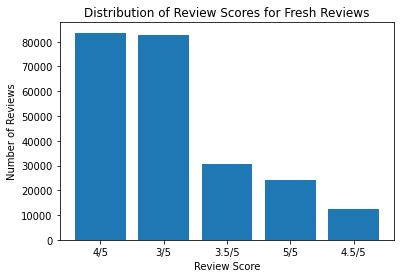

In [ ]:
# You call this a fresh review??
# Let's keep only the fresh reviews with a score of 3/5 or higher.
fresh_scores = ["3/5", "3.5/5", "4/5", "4.5/5", "5/5"]
fresh_reviews = fresh_reviews[fresh_reviews["review_score"].isin(fresh_scores)]
print("Number of fresh reviews:", len(fresh_reviews))
fresh_reviews_score_counts = fresh_reviews["review_score"].value_counts()
display(fresh_reviews_score_counts)

plt.bar(fresh_reviews_score_counts.index, fresh_reviews_score_counts.values)
plt.xlabel("Review Score")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Review Scores for Fresh Reviews")
plt.show()

Number of reviews: 344602


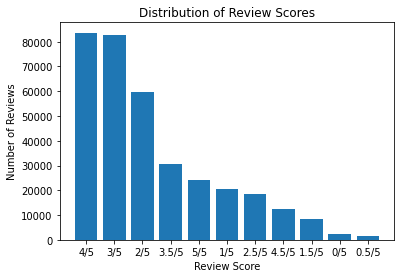

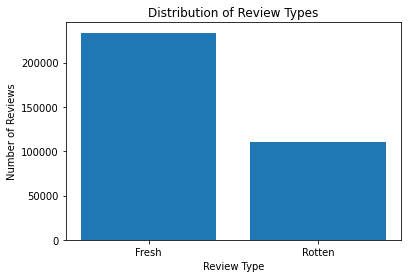

In [ ]:
# Let's stack the rotten and fresh reviews together.
reviews_df = pd.concat([rotten_reviews, fresh_reviews])
print("Number of reviews:", len(reviews_df))
# And let's count the number of reviews for each review score.
reviews_score_counts = reviews_df["review_score"].value_counts()
#display(reviews_score_counts)
review_type_counts = reviews_df["review_type"].value_counts()
#display(review_type_counts)

# Create a bar chart for review score counts
plt.bar(reviews_score_counts.index, reviews_score_counts.values)
plt.xlabel("Review Score")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Review Scores")

# Create a bar chart for review type counts
plt.figure()
plt.bar(review_type_counts.index, review_type_counts.values)
plt.xlabel("Review Type")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Review Types")

plt.show()

In [ ]:
# For how we subset the data we should have from  0/5 to 2.5/5 only rotten reviews and from 3/5 to 5/5 only fresh reviews.
# Let's check if this is true.
# First for the rotten reviews
check_rotten_reviews = reviews_df[
    reviews_df["review_score"].isin(["0/5", "0.5/5", "1/5", "1.5/5", "2/5", "2.5/5"])
]
true_rotten_reviews = reviews_df[reviews_df["review_type"] == "Rotten"]
print("Number of rotten scores:", len(check_rotten_reviews))
print("Number of rotten reviews:", len(true_rotten_reviews))
# And then for the fresh reviews
check_fresh_reviews = reviews_df[
    reviews_df["review_score"].isin(["3/5", "3.5/5", "4/5", "4.5/5", "5/5"])
]
true_fresh_reviews = reviews_df[reviews_df["review_type"] == "Fresh"]
print("Number of fresh scores:", len(check_fresh_reviews))
print("Number of fresh reviews:", len(true_fresh_reviews))

Number of rotten scores: 110813
Number of rotten reviews: 110813
Number of fresh scores: 233789
Number of fresh reviews: 233789


In [ ]:
# But we need to take care of the duplicates...
# Let's get rid of the reviews without an actual content and duplicates.

print("Number of reviews before dropping duplicates:", len(reviews_df))
nodup_reviews_df = reviews_df.dropna().drop_duplicates()
print("Number of reviews after dropping duplicates:", len(nodup_reviews_df))
# display(nodup_reviews_df)

Number of reviews before dropping duplicates: 344602
Number of reviews after dropping duplicates: 268469


In [ ]:
# Let's check again the distribution of the review scores.
nodup_reviews_score_counts = nodup_reviews_df["review_score"].value_counts()
display(nodup_reviews_score_counts)

4/5      65988
3/5      62349
2/5      44255
3.5/5    26397
5/5      18524
2.5/5    15633
1/5      15255
4.5/5    10522
1.5/5     6842
0/5       1530
0.5/5     1174
Name: review_score, dtype: int64

In [ ]:
# Overwrite
reviews_df = nodup_reviews_df

In [ ]:
# Let's check again the distribution of the review scores.
check_rotten_reviews = reviews_df[
    reviews_df["review_score"].isin(["0/5", "0.5/5", "1/5", "1.5/5", "2/5", "2.5/5"])
]
true_rotten_reviews = reviews_df[reviews_df["review_type"] == "Rotten"]
print("Number of rotten scores:", len(check_rotten_reviews))
print("Number of rotten reviews:", len(true_rotten_reviews))
# And then for the fresh reviews
check_fresh_reviews = reviews_df[
    reviews_df["review_score"].isin(["3/5", "3.5/5", "4/5", "4.5/5", "5/5"])
]
true_fresh_reviews = reviews_df[reviews_df["review_type"] == "Fresh"]
print("Number of fresh scores:", len(check_fresh_reviews))
print("Number of fresh reviews:", len(true_fresh_reviews))

Number of rotten scores: 84689
Number of rotten reviews: 84689
Number of fresh scores: 183780
Number of fresh reviews: 183780


In [ ]:
# Everything adds up :)
# So now, to have a balanced test, we can take some random samples equally
# from all the different scores, but careful... there are 6 scores for the rotten reviews and 5 for the fresh reviews.
# We'll take 1000 samples from each of the scores, but to balance things out we'll take 2000 samples from the score 3/5

clean_reviews_df = pd.DataFrame(columns=reviews_df.columns)
N_SAMPLES = 1000
for score in rotten_scores + fresh_scores:
    if score == "3/5":
        score_reviews = reviews_df[reviews_df["review_score"] == score].sample(
            2 * N_SAMPLES, random_state=2023
        )
    else:
        score_reviews = reviews_df[reviews_df["review_score"] == score].sample(
            N_SAMPLES, random_state=2023
        )
    clean_reviews_df = pd.concat([clean_reviews_df, score_reviews])

In [ ]:
# Let's check if we have the same number of reviews for each score.
clean_reviews_score_counts = clean_reviews_df["review_score"].value_counts()
display(clean_reviews_score_counts)
clean_review_type_counts = clean_reviews_df["review_type"].value_counts()
display(clean_review_type_counts)

3/5      2000
0/5      1000
0.5/5    1000
1/5      1000
1.5/5    1000
2/5      1000
2.5/5    1000
3.5/5    1000
4/5      1000
4.5/5    1000
5/5      1000
Name: review_score, dtype: int64

Rotten    6000
Fresh     6000
Name: review_type, dtype: int64

In [ ]:
print("Number of reviews before dropping duplicates:", len(clean_reviews_df))
nodup_clean_reviews_df = clean_reviews_df.dropna().drop_duplicates()
print("Number of reviews after dropping duplicates:", len(nodup_clean_reviews_df))

Number of reviews before dropping duplicates: 12000
Number of reviews after dropping duplicates: 12000


In [ ]:
# Very well, it means that when we dropped the duplicates before we actually did that well.
# But double check is always good :)

In [ ]:
# Overwrite
clean_reviews_df = nodup_clean_reviews_df

In [ ]:
# Let's get rid of the reviews without an actual content
print("Number of reviews before dropping insignificant reviews:", len(clean_reviews_df))
nonull_clean_reviews_df = clean_reviews_df[
    ~clean_reviews_df["review_content"].str.contains("click for full review")
]
print("Number of reviews after dropping insignificant reviews:", len(nonull_clean_reviews_df))
display(nonull_clean_reviews_df.sample(10, random_state=2023))

Number of reviews before dropping insignificant reviews: 12000
Number of reviews after dropping insignificant reviews: 12000


,review_type,review_score,review_content
1080705,Fresh,4/5,The extraordinary improvisational performances...
1052186,Rotten,0/5,AT the centre of our galaxy is a supermassive ...
500681,Rotten,2/5,The argument for Cobain's brilliance never qui...
68453,Fresh,3/5,"An old fashioned, professionally executed thri..."
208958,Fresh,3/5,Those who like things sentimental and sweet - ...
73752,Fresh,3.5/5,"It's a good movie, but definitely a few notche..."
935729,Fresh,4.5/5,Though it has the potential for real greatness...
473690,Fresh,3/5,As artful as it is appetizing.
692722,Fresh,4/5,Manages to integrate the [internet's] simultan...
349439,Rotten,1/5,There's plenty of singing and haircutting and ...


In [ ]:
# Again, the drop_duplicates() method already removed all those reviews with "click for full review"

In [ ]:
# By lucky chance, while creating this notebook,
# we could see that there are some reviews in other languages..
# better to get rid of them.


def detect_english_language(text):
    try:
        return langdetect.detect(text) == "en"
    except:
        return False

In [ ]:
len(clean_reviews_df)

12000

In [ ]:
# ATTENTION: It will take some time...
# Let's keep only the reviews in English.
en_clean_reviews = clean_reviews_df[
    clean_reviews_df["review_content"].apply(detect_english_language)
]
display(en_clean_reviews)

,review_type,review_score,review_content
79070,Rotten,0/5,"Not a good time. Seriously, really not a good ..."
266306,Rotten,0/5,One of the most painfully bad films I have eve...
1111952,Rotten,0/5,A waste of celluloid.
999045,Rotten,0/5,"Carrey gives the worst performance of his, or ..."
361790,Rotten,0/5,UFOs in Brooklyn? Fuggedaboutit!
...,...,...,...
323917,Fresh,5/5,"Don't phone home, phone the theater and buy ti..."
54113,Fresh,5/5,"A skin-crawling, gut-busting, Karo-syrup cover..."
237627,Fresh,5/5,"Its plump chickens maintain that strange, hapt..."
468398,Fresh,5/5,"This is a cinema of no escape, and few if any ..."


In [ ]:
# Let's see some of the non-english reviews.
non_en_reviews = clean_reviews_df.drop(en_clean_reviews.index)
print("Number of non-english reviews:", len(non_en_reviews))
display(non_en_reviews.sample(30))

Number of non-english reviews: 262


,review_type,review_score,review_content
1041180,Rotten,2/5,Talent-swapping basketball tale is bland but O...
718068,Fresh,3/5,engaging but a bit pointless
57989,Fresh,4/5,Crash a beau avoir du contenu il n'est jamais ...
506646,Rotten,1.5/5,"a staid, interminable miscalculation"
54713,Rotten,2.5/5,...va dans toutes les directions sans choisir ...
918192,Rotten,1/5,embarrasses a horror icon
1036012,Rotten,1/5,impressionante que 13 Fantasmas tenha sido mon...
53141,Fresh,4/5,unique
804010,Fresh,5/5,"C'est simple: si vous avez aim Shrek, vous ado..."
1093580,Rotten,2.5/5,A colorful but superficial mess.


In [ ]:
# Not what we expected, there are too many false positives.. but anyway...

In [ ]:
# How did the value counts change after removing the non-english reviews?
en_clean_reviews_score_counts = en_clean_reviews["review_score"].value_counts()
display(en_clean_reviews_score_counts)

3/5      1959
2.5/5     990
4.5/5     988
3.5/5     984
1.5/5     983
0.5/5     982
2/5       982
4/5       982
0/5       971
5/5       959
1/5       958
Name: review_score, dtype: int64

In [ ]:
# Let's re-sample again
clean_reviews_df = pd.DataFrame(columns=reviews_df.columns)
N_SAMPLES = 950
reviews_df = en_clean_reviews
for score in rotten_scores + fresh_scores:
    if score == "3/5":
        score_reviews = reviews_df[reviews_df["review_score"] == score].sample(
            2 * N_SAMPLES, random_state=2023
        )
    else:
        score_reviews = reviews_df[reviews_df["review_score"] == score].sample(
            N_SAMPLES, random_state=2023
        )
    clean_reviews_df = pd.concat([clean_reviews_df, score_reviews])

In [ ]:
display(clean_reviews_df.value_counts("review_score"))
display(clean_reviews_df.value_counts("review_type"))

review_score
3/5      1900
0.5/5     950
0/5       950
1.5/5     950
1/5       950
2.5/5     950
2/5       950
3.5/5     950
4.5/5     950
4/5       950
5/5       950
dtype: int64

review_type
Fresh     5700
Rotten    5700
dtype: int64

In [ ]:
# Let's do one last more adjustment before we start with the actual sentiment analysis.
# We'll map the string scores to actual numerical values.
# We'll map the review type to numerical values as well: 0 for rotten and 1 for fresh.


def map_score_to_number(score):
    if score == "0/5":
        return 0
    elif score == "0.5/5":
        return 0.5
    elif score == "1/5":
        return 1
    elif score == "1.5/5":
        return 1.5
    elif score == "2/5":
        return 2
    elif score == "2.5/5":
        return 2.5
    elif score == "3/5":
        return 3
    elif score == "3.5/5":
        return 3.5
    elif score == "4/5":
        return 4
    elif score == "4.5/5":
        return 4.5
    elif score == "5/5":
        return 5


def map_review_type_to_number(review_type):
    if review_type == "Rotten":
        return 0
    elif review_type == "Fresh":
        return 1

In [ ]:
clean_reviews_df = clean_reviews_df.assign(
    review_score=clean_reviews_df["review_score"].apply(map_score_to_number)
)

clean_reviews_df = clean_reviews_df.assign(
    review_type=clean_reviews_df["review_type"].apply(map_review_type_to_number)
)

display(clean_reviews_df.sample(20))

,review_type,review_score,review_content
238635,1,3,Though this version adds little to Chucky's my...
300897,0,1.5,As scattered as it is senseless.
572676,1,4.5,This is a film that lives or dies on its artis...
739527,0,0.5,... the picture ranks among the year's most co...
878813,0,1.5,Tatum and Dewan have no chemistry while dancin...
684768,1,4.5,Stephen Frears' sublimely nimble evisceration ...
484530,0,1.5,In spite of the title you will not want to Jus...
263836,1,3.5,The fight choreography is on point and the sou...
194966,1,4.5,A searing portrait of the disintegration of no...
773624,1,3.5,...an unlikely but successful hybrid: a police...


In [ ]:
# Save to a csv file the results obtained so far.
# clean_reviews_df.to_csv("clean_reviews.csv", index=False)

In [ ]:
# ---------------------------------------------------------- #
# ------------------- Sentiment Analysis ------------------- #
# ---------------------------------------------------------- #

In [ ]:
reviews_df = clean_reviews_df

In [ ]:
# reviews_df = pd.read_csv("clean_reviews.csv")
display(reviews_df.sample(10))

,review_type,review_score,review_content
156238,0,0.5,There isn't a single note in this movie that r...
621804,1,3.5,"All things considered, the fact that Ocean's 1..."
451033,1,3,The result feels just as long as the original ...
82369,1,3.5,"Despite its flaws, Wonderland is stuffed with ..."
229683,0,0.5,The 3D conversion is awful. The special effect...
240297,0,0,Let's be blunt. This is an evil film. It defam...
811914,0,0.5,It's as painful to watch as Rodman's star-post...
965223,0,2,There are one or two good jokes and the cast i...
282170,1,3,"Like its subject, the movie is not as calculat..."
1041311,0,0.5,"Ugly, disturbing, and misguided mess."


In [ ]:
# ========================================
# ===== Preprocessing the text data ======
# ========================================


def preprocess_text(text):
    # Removing numerical data or irrelevant characters
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Tokenization
    tokens = nltk.word_tokenize(text)
    # Lowercasing
    tokens = [token.lower() for token in tokens]
    # Removing stopwords
    tokens = [token for token in tokens if token not in stopwords.words("english")]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Joining the tokens back to a string
    text = " ".join(tokens)
    return text

In [ ]:
# ATTENTION: It will take some time again
reviews_df["review_content"] = reviews_df["review_content"].apply(preprocess_text)
display(reviews_df.sample(10))

,review_type,review_score,review_content
389002,0,0.5,like dead kitty left rot grandma couch movie s...
137080,1,3.5,alex garland beautifully subverts cliche fanta...
675427,0,2.5,someone involved production made horrible mist...
1000675,1,4.5,smartly edited utterly engrossing intelligent ...
295557,1,5,time always fly tarantino give u lot movie money
940047,1,3.5,conjuring slow moment bit shorter two hour tec...
832410,1,3.5,extremely visceral experience much say contemp...
571576,1,5,still powerful story two loser new york
1106545,1,4,widow slow start buffer screentime awesome finish
425012,0,0,im still marvelling ive actually seen


In [ ]:
# Save to a file the preprocessed reviews.
# reviews_df.to_csv("preprocessed_reviews.csv", index=False)

In [ ]:
# ==========================================
# =========== Embedding the data ===========
# ==========================================

# We have two main choices for the embedding of the text data with Gensim:
# 1. Word2Vec
# 2. GloVe

# reviews_df = pd.read_csv("preprocessed_reviews.csv")

In [ ]:
reviews_df.isnull().sum()

review_type       0
review_score      0
review_content    0
dtype: int64

In [ ]:
dna_reviews_df = reviews_df.dropna()
print("Number of reviews after dropping NaNs:", len(dna_reviews_df))
dna_reviews_df.isnull().sum()

Number of reviews after dropping NaNs: 11400


review_type       0
review_score      0
review_content    0
dtype: int64

In [ ]:
# dna_reviews_df.to_csv("preprocessed_reviews.csv", index=False)

In [ ]:
# reviews_df = pd.read_csv("preprocessed_reviews.csv")

In [ ]:
reviews_df.describe()

,review_type,review_score
count,1.14e+04,1.14e+04
mean,0.5,2.542
std,0.5,1.52
min,0,0
25%,0,1.375
50%,0.5,2.75
75%,1,3.625
max,1,5


In [ ]:
# REMINDER: as long as we work on the binary classification, this dataset
# is pretty balanced, but if we want to do a regression to estimate the
# score of a review, then we have to drop the 1000 reviews from the score 3/5
# that we have kept for balancing the reviews according to the type (fresh/rotten).

In [ ]:
# Let's start with Word2Vec.

text = " ".join(reviews_df["review_content"].tolist())
words = text.split()
model = Word2Vec([words], min_count=1)
model.save("word2vec.model")

In [ ]:
embeddings = []
vocabulary = []

for word in model.wv.index2word:
    embeddings.append(model.wv[word])
    vocabulary.append(word)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(embeddings)

sample_words = random.sample(vocabulary, 100)
sample_embeddings = [embeddings[vocabulary.index(word)] for word in sample_words]

In [ ]:
print("Vocabulary size: {}".format(len(vocabulary)))

Vocabulary size: 20892


In [ ]:
df = pd.DataFrame(principal_components, columns=["PC1", "PC2"])
df["word"] = vocabulary

# N_SAMPLES = 500
# df = df.sample(n=N_SAMPLES, replace=False, random_state=42)

sns.set(style="ticks")
fig, ax = plt.subplots(figsize=(120, 120))
sns.scatterplot(data=df, x="PC1", y="PC2", legend=False)
for i, row in df.iterrows():
    plt.annotate(row["word"], (row["PC1"], row["PC2"]))
plt.show()

In [ ]:
plt.savefig("rotten_tomatoes-word2vec.png", dpi=300, bbox_inches="tight")

<Figure size 432x288 with 0 Axes>

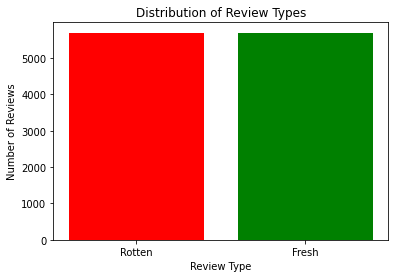

In [ ]:
# Final Dataset that is obtained after pre-processing 
# Get the count of reviews by review type
review_type_counts = reviews_df["review_type"].value_counts()

# Define the colors for the bar chart
colors = ["red", "green"]

# Plot the bar chart with different colors and labels
plt.bar(x=["Rotten", "Fresh"], height=review_type_counts.values, color=colors)
plt.xlabel("Review Type")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Review Types")
plt.xticks(rotation=0)
plt.show()


In [ ]:
# Another way to look at the words' distribution... the WordCloud.

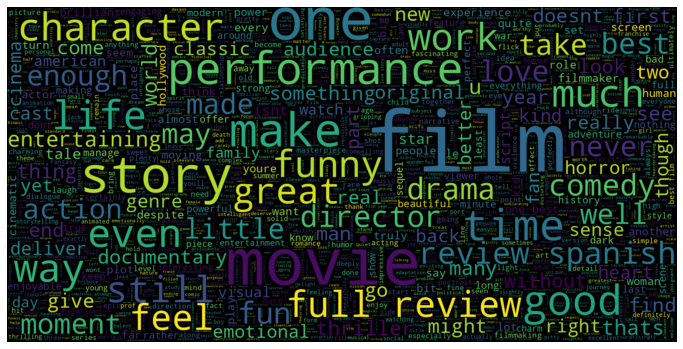

In [ ]:
# WordCloud for positive reviews:
positive_reviews = reviews_df[reviews_df["review_type"] == 1].review_content
positive_reviews_text = " ".join(positive_reviews)

wordcloud = WordCloud(
    max_words=2000, width=1600, height=800, max_font_size=200
).generate(positive_reviews_text)

plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

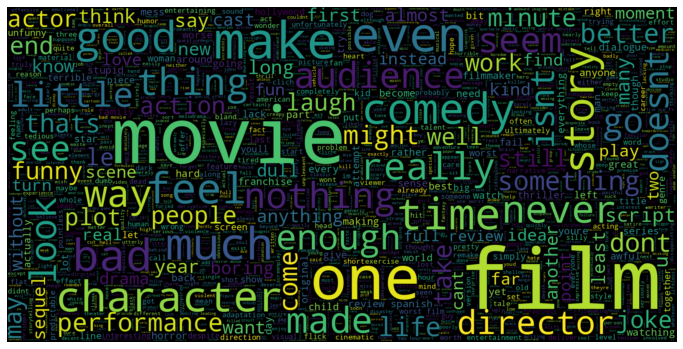

In [ ]:
# WordCloud for negative reviews:
negative_reviews = reviews_df[reviews_df["review_type"] == 0].review_content
negative_reviews_text = " ".join(negative_reviews)

wordcloud = WordCloud(
    max_words=2000, width=1600, height=800, max_font_size=200
).generate(negative_reviews_text)

plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

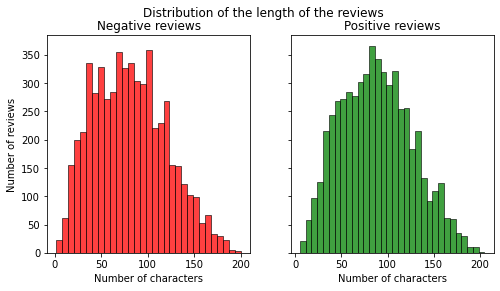

In [ ]:
# Let's have a look at the length of the reviews
#   (in terms of number of characters).
text_len_neg = negative_reviews.str.len()
text_len_pos = positive_reviews.str.len()

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
sns.histplot(
    text_len_neg, ax=ax[0], color="red", label="Negative reviews", multiple="dodge"
)
sns.histplot(
    text_len_pos, ax=ax[1], color="green", label="Positive reviews", multiple="dodge"
)

ax[0].set_title("Negative reviews")
ax[0].set_xlabel("Number of characters")
ax[0].set_ylabel("Number of reviews")

ax[1].set_title("Positive reviews")
ax[1].set_xlabel("Number of characters")
ax[1].set_ylabel("Number of reviews")

fig.suptitle("Distribution of the length of the reviews")
plt.show()

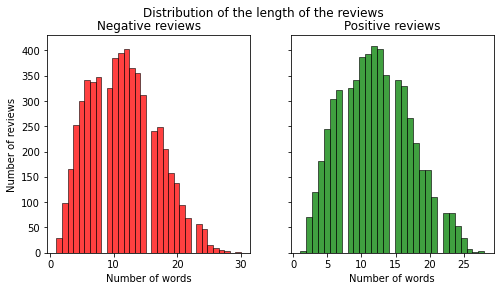

In [ ]:
#   (and now in terms of number of words)

text_wc_neg = negative_reviews.str.split().map(lambda x: len(x))
text_wc_pos = positive_reviews.str.split().map(lambda x: len(x))

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

sns.histplot(
    text_wc_neg, ax=ax[0], color="red", label="Negative reviews", multiple="dodge"
)
sns.histplot(
    text_wc_pos, ax=ax[1], color="green", label="Positive reviews", multiple="dodge"
)

ax[0].set_title("Negative reviews")
ax[0].set_xlabel("Number of words")
ax[0].set_ylabel("Number of reviews")

ax[1].set_title("Positive reviews")
ax[1].set_xlabel("Number of words")
ax[1].set_ylabel("Number of reviews")

fig.suptitle("Distribution of the length of the reviews")
plt.show()

##Applying the prepreocessed data to the model

In [ ]:
# ========================================= #
# ============ DISCLAIMER ================= #
# ========================================= #

# Big part of the code used for this sentiment analysis
# is taken from the code provided during the lectures of the course 
#            "DEEP LEARNING (2022)" 
# taken at 
# 
#             UNIVERSITA' DEGLI STUDI DI BRESCIA 
#             ( https://www.unibs.it/it )
# 
# taught by   PROF. IVAN SERINA
#             ( https://ivan-serina.unibs.it )

# In particular, 
#  - the code used to define the model on top of BERT
#  - the function preprocessing_for_bert(data, max_len)

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 95.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 20.7 MB/s eta 0:00:00


In [ ]:
from pathlib import Path
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA
from wordcloud import WordCloud
from transformers import BertModel, BertTokenizer
from sklearn.metrics import accuracy_score
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


import matplotlib.pyplot as plt
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import nltk
import gensim
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
ROOT = Path() # PUT HERE WHERE YOU DESIRE TO SAVE THE TRAINED MODELS

In [ ]:
RANDOM_STATE = 2023

TEST_SIZE = 0.2
VALIDATION_SIZE = 0.2

In [ ]:
# Create a function to tokenize a set of texts
def preprocessing_for_bert(data, max_len):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text = sent,  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=max_len,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

TASKS:
- Classification (binary: [Rotten/Fresh])
- Regression: [0-5]

# CLASSIFICATION

In [ ]:
# reviews_df = pd.read_csv(ROOT / "preprocessed_reviews.csv")

# Sample just a portion of the data
# perc = 0.99
# reviews_df = reviews_df.sample(frac=perc, random_state=RANDOM_STATE)

X = reviews_df['review_content'].values
y = reviews_df['review_type'].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# For later use in manual testing phase
X_test_d = pd.DataFrame(X_test, columns=["review_content"])
y_test_d = pd.DataFrame(y_test, columns=["review_type"])

class_testing_phase_df = pd.concat([y_test_d, X_test_d], axis=1)

X_train, X_val, y_train, y_val =\
    train_test_split(X_train, y_train, test_size=VALIDATION_SIZE, random_state=RANDOM_STATE)

# Tokenize the input text

# From the histogram we saw that all the reviews
# are shorter than 30 tokens.
max_len = 30

# Run function `preprocessing_for_bert` on the train set, the validation set and the test set
train_inputs, train_masks = preprocessing_for_bert(X_train, max_len)
val_inputs, val_masks = preprocessing_for_bert(X_val, max_len)
test_inputs, test_masks = preprocessing_for_bert(X_test, max_len)

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)
test_labels = torch.tensor(y_test)

# For fine-tuning BERT, it's recommended a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=1)

print('Head of the test set')
display(class_testing_phase_df.head())

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Head of the test set


,review_type,review_content
0,1,epic king arthur saga illicit affair brutality
1,1,summer big expensive superhero flick moonrise ...
2,1,film reminds u straightup romance far day genr...
3,0,porkieslite college comedy offer virtually not...
4,1,washington customarily magnetic davis film


In [ ]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [ ]:
class BertForSentimentAnalysis(nn.Module):
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertForSentimentAnalysis, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        
        D_in, H, D_out = 768, 100, 2 #The hidden level can be changed to improve the performances!

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.1), #Try to change the dropout value to improve the performances
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        pooled_output = outputs.pooler_output
        # Extract the last hidden state of the token `[CLS]` for classification task
        # last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(pooled_output)

        return logits

In [ ]:
def train(model, train_dataloader, optimizer, criterion):
    model.train()
    total_loss, total_acc = 0, 0
    for step, batch in enumerate(train_dataloader):
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask=attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += accuracy_score(torch.argmax(logits, axis=1).cpu().numpy(), labels.cpu().numpy())
    return total_loss/len(train_dataloader), total_acc/len(train_dataloader)


def evaluate(model, val_dataloader, criterion):
    model.eval()
    total_loss, total_acc = 0, 0
    with torch.no_grad():
        for step, batch in enumerate(val_dataloader):
            input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
            logits = model(input_ids, attention_mask=attention_mask)
            loss = criterion(logits, labels)
            total_loss += loss.item()
            total_acc += accuracy_score(torch.argmax(logits, axis=1).cpu().numpy(), labels.cpu().numpy())
    return total_loss/len(val_dataloader), total_acc/len(val_dataloader)

In [ ]:
model = BertForSentimentAnalysis(freeze_bert=False)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# ATTENTION: RUN IT ONLY IF YOU HAVE SOME TIME AT DISPOSAL
train_losses = []
train_accs = []
val_losses = []
val_accs = []

num_epochs = 5
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_dataloader, criterion)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f'Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f} - Training Accuracy: {train_acc:.4f} - Validation Loss: {val_loss:.4f} - Validation Accuracy: {val_acc:.4f}')


Epoch 1/5 - Training Loss: 0.5396 - Training Accuracy: 0.7287 - Validation Loss: 0.4299 - Validation Accuracy: 0.8134
Epoch 2/5 - Training Loss: 0.3678 - Training Accuracy: 0.8421 - Validation Loss: 0.4160 - Validation Accuracy: 0.8160
Epoch 3/5 - Training Loss: 0.2214 - Training Accuracy: 0.9178 - Validation Loss: 0.5107 - Validation Accuracy: 0.8079
Epoch 4/5 - Training Loss: 0.1318 - Training Accuracy: 0.9531 - Validation Loss: 0.6085 - Validation Accuracy: 0.8171
Epoch 5/5 - Training Loss: 0.0882 - Training Accuracy: 0.9723 - Validation Loss: 0.5881 - Validation Accuracy: 0.8144


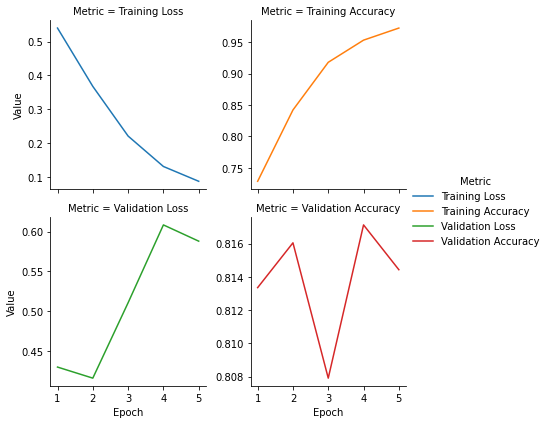

In [ ]:
data = {
    'Epoch': range(1, num_epochs+1),
    'Training Loss': train_losses,
    'Training Accuracy': train_accs,
    'Validation Loss': val_losses,
    'Validation Accuracy': val_accs
}

trends = pd.DataFrame(data)

trends = trends.melt(id_vars=['Epoch'], var_name='Metric', value_name='Value')

# Create a facet grid with subplots for each metric
g = sns.FacetGrid(trends, col='Metric', hue='Metric', col_wrap=2, sharey=False)
g.map(sns.lineplot, 'Epoch', 'Value')

# Set the axis labels and legend
g.set_axis_labels('Epoch', 'Value')
g.add_legend()

# Show the plot
plt.show()

In [ ]:
torch.save(model.state_dict(), ROOT / "unibs-binary-nofreeze-pooled.pth")

In [ ]:
bert_classification = BertForSentimentAnalysis()
bert_classification.load_state_dict(torch.load(ROOT / "unibs-binary-nofreeze-pooled.pth"))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [ ]:
bert_classification.to(device)

In [ ]:
def predict(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()
    predictions=[]
    # Tracking variables
    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()
        predictions.append(int(preds.detach().cpu().numpy()))

    return predictions

In [ ]:
predictions = predict(bert_classification, test_dataloader)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.83      0.78      0.80      1155
           1       0.79      0.84      0.81      1161

    accuracy                           0.81      2316
   macro avg       0.81      0.81      0.81      2316
weighted avg       0.81      0.81      0.81      2316



# REGRESSION

In [ ]:
reviews_df = reviews_df.drop(columns=['review_type'])
# First we need to rescale the values from [0,5] to [0,1]
reviews_df['review_score'] = reviews_df['review_score'] / 5.0

In [ ]:
reviews_df.sample(10)

,review_score,review_content
410555,1,filled dramatic tension complex character rich...
100609,0.9,soulstirring screen adaptation henrik ibsen br...
127316,0.6,formidable acting duo story need retelling the...
1030492,1,since grey garden film invited u strange barel...
235903,0.3,bunch meanspirited child totally control teari...
676439,1,moving documentary survivor lead u reflect upo...
748436,0.3,director seems buy author fond autoenshrinemen...
296743,0.6,chapiron never let thing get boring even cant ...
136139,0.1,expect dialogue stilted effect tacky scary thi...
486156,0.6,fun feelgood way spend couple hour actually in...


In [ ]:
# Sample just a portion of the data
# perc = 0.25
# reviews_df = reviews_df.sample(frac=perc, random_state=RANDOM_STATE)

X = reviews_df['review_content'].values
y = reviews_df['review_score'].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

X_train, X_val, y_train, y_val =\
    train_test_split(X_train, y_train, test_size=VALIDATION_SIZE, random_state=RANDOM_STATE)

# For later use in manual testing phase
X_test_d = pd.DataFrame(X_test, columns=["review_content"])
y_test_d = pd.DataFrame(y_test, columns=["review_score"])

regress_testing_phase_df = pd.concat([y_test_d, X_test_d], axis=1)

# Tokenize the input text

max_len = 30

# Run function `preprocessing_for_bert` on the train set, the validation set and the test set
train_inputs, train_masks = preprocessing_for_bert(X_train, max_len)
val_inputs, val_masks = preprocessing_for_bert(X_val, max_len)
test_inputs, test_masks = preprocessing_for_bert(X_test, max_len)

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)
test_labels = torch.tensor(y_test)

# For fine-tuning BERT, it's recommended a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=1)

print('Head of the test set')
display(regress_testing_phase_df.head())

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Head of the test set


,review_score,review_content
0,0.6,epic king arthur saga illicit affair brutality
1,1,summer big expensive superhero flick moonrise ...
2,0.6,film reminds u straightup romance far day genr...
3,0.2,porkieslite college comedy offer virtually not...
4,0.6,washington customarily magnetic davis film


In [ ]:
class BertForSentimentRegression(nn.Module):
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertForSentimentRegression, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        
        D_in, H, D_out = 768, 100, 1 #The hidden level can be changed to improve the performances!

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.regressor = nn.Sequential(
            nn.Dropout(0.1), #Try to change the dropout value to improve the performances
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Linear(H, D_out)
        )

        self.double()

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        pooled_output = outputs.pooler_output
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        # last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        regression_output = self.regressor(pooled_output)

        return regression_output.squeeze(-1)

In [ ]:
def train(model, train_dataloader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(train_dataloader):
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
        # input_ids = batch['input_ids'].to(device)
        # attention_mask = batch['attention_mask'].to(device)
        # labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(train_dataloader)


def evaluate(model, val_dataloader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(val_dataloader):
            input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)

            epoch_loss += loss.item()

    return epoch_loss / len(val_dataloader)


In [ ]:
model = BertForSentimentRegression(freeze_bert=False)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.MSELoss()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_losses = []
val_losses = []

num_epochs = 5

for epoch in range(num_epochs):
    train_loss = train(model, train_dataloader, optimizer, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(train_loss)
    val_loss = evaluate(model, val_dataloader, criterion, device)
    print(f"Epoch {epoch+1}. Train loss: {train_loss:.5f}. Validation loss: {val_loss:.5f}")


Epoch 1. Train loss: 0.08438. Validation loss: 0.05635
Epoch 2. Train loss: 0.04752. Validation loss: 0.05511
Epoch 3. Train loss: 0.03253. Validation loss: 0.05918
Epoch 4. Train loss: 0.02208. Validation loss: 0.05604
Epoch 5. Train loss: 0.01628. Validation loss: 0.05332


In [ ]:
torch.save(model.state_dict(), ROOT / "unibs-regression-nofreeze-pooled.pth")

In [ ]:
bert_regression = BertForSentimentRegression()
bert_regression.load_state_dict(torch.load(ROOT / "unibs-regression-nofreeze-pooled.pth"))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [ ]:
bert_regression.to(device)

In [ ]:
def predict(model, test_dataloader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids, attention_mask, _ = tuple(t.to(device) for t in batch)

            outputs = model(input_ids, attention_mask=attention_mask)
            predictions.extend(outputs.tolist())

    return predictions

In [ ]:
predictions = predict(model, test_dataloader)
targets = y_test

mse = mean_squared_error(targets, predictions)
rmse = mean_squared_error(targets, predictions, squared=False)
mae = mean_absolute_error(targets, predictions)
r2 = r2_score(targets, predictions)

print(f"MSE: {mse:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"MAE: {mae:.5f}")
print(f"R2: {r2:.5f}")

MSE: 0.05843
RMSE: 0.24173
MAE: 0.18152
R2: 0.42351


In [ ]:
# ============================================== #
# =============== Manual Testing =============== #
# ============================================== #

In [ ]:
bert_classification = BertForSentimentAnalysis()
bert_classification.load_state_dict(torch.load(ROOT / "unibs-binary-nofreeze-pooled.pth"))

bert_regression = BertForSentimentRegression()
bert_regression.load_state_dict(torch.load(ROOT / "unibs-regression-nofreeze-pooled.pth"))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.trans

<All keys matched successfully>

In [ ]:
def preprocess_text(text):
    # Removing numerical data or irrelevant characters
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Tokenization
    tokens = nltk.word_tokenize(text)
    # Lowercasing
    tokens = [token.lower() for token in tokens]
    # Removing stopwords
    tokens = [token for token in tokens if token not in stopwords.words("english")]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Joining the tokens back to a string
    text = " ".join(tokens)
    return text

In [ ]:
def custom_classification_test(model, text):
    inputs = tokenizer(text, return_tensors='pt')
    outputs = model(inputs['input_ids'], inputs['attention_mask'])
    predicted_class = torch.argmax(outputs[0])
    return 'Fresh' if predicted_class == 1 else 'Rotten'

In [ ]:
def custom_regression_test(model, text, mult):
    input = tokenizer(text, return_tensors='pt')
    output = model(input['input_ids'], input['attention_mask'])
    return output.item() * float(mult)

In [ ]:
reviews = pd.read_csv(ROOT / "clean_reviews.csv")
reviews = reviews.sample(50, random_state=RANDOM_STATE+1)

for r in reviews.iterrows():
    _, r = r
    review_type, review_score, review_content = r
    # print(r)eview_type, review_score, review_content = r
    print('REVIEW:')
    print(review_content)

    text = preprocess_text(review_content)

    print('True type:', 'Rotten' if review_type == 0 else 'Fresh')
    print('Predicted type:', custom_classification_test(bert_classification, text))

    print('True score:', review_score)
    print('Predicted score:', custom_regression_test(bert_regression, text, 5))

REVIEW:
Aimless, sloppy, low-budget garbage that will prove especially painful to endure for long-time Kevin Smith fans. Where did all that zeitgeist savvy go?
True type: Rotten
Predicted type: Rotten
True score: 0.5
Predicted score: 0.7563454390599058
REVIEW:
[Washington] has a terrific cast at his disposal.
True type: Fresh
Predicted type: Fresh
True score: 3.0
Predicted score: 3.2764272219320056
REVIEW:
My Cousin Rachel belongs to Weisz, in a role that capitalises on her gift for showing multiple layers of emotion.
True type: Fresh
Predicted type: Fresh
True score: 3.0
Predicted score: 3.2818575735365316
REVIEW:
Some of the phallic jokes work, others are really lame. Fortunately there are many other funny bits that have nothing to do with body parts that keep the laughs coming.
True type: Fresh
Predicted type: Fresh
True score: 3.0
Predicted score: 1.36877654277474
REVIEW:
I think it was after Betty White told Steve Martin's son not to "wear his hair like a ***" that I thought about

In [ ]:
# TESTING ON THE TEST SETS
# CLASSIFICATION TASK
reviews = class_testing_phase_df
reviews = reviews.sample(20, random_state=RANDOM_STATE+1)
for r in reviews.iterrows():
    _, r = r
    review_type, review_content = r
    print('REVIEW:')
    print(review_content)

    text = preprocess_text(review_content)

    print('True type:', 'Rotten' if review_type == 0 else 'Fresh')
    print('Predicted type:', custom_classification_test(bert_classification, text))

print('============================')

reviews = regress_testing_phase_df
reviews = reviews.sample(20, random_state=RANDOM_STATE+1)
for r in reviews.iterrows():
    _, r = r
    review_score, review_content = r
    print('REVIEW:')
    print(review_content)

    text = preprocess_text(review_content)

    print('True score:', review_score)
    print('Predicted score:', custom_regression_test(bert_regression, text, 1))



REVIEW:
plenty diverting stylistic perspective story behind flair positively stoneage
True type: Rotten
Predicted type: Fresh
REVIEW:
earnest amateurish tween fairy tale set south sea
True type: Rotten
Predicted type: Rotten
REVIEW:
funny fit start wearing welcome short order
True type: Rotten
Predicted type: Rotten
REVIEW:
mindless dumb fun arnie grunt one liner try terminate escaped drug lord who fast car heading freedom
True type: Rotten
Predicted type: Rotten
REVIEW:
quirky nihilistic
True type: Fresh
Predicted type: Fresh
REVIEW:
death wish nra member wet dream perfect film america exists poisoned imagination pathetic wouldbe bully white house
True type: Rotten
Predicted type: Rotten
REVIEW:
movie cant decide want wellobserved urban relationship drama madcap comedy
True type: Rotten
Predicted type: Rotten
REVIEW:
paul walter hauser reason see film witnessing hauser emergence riveting actor dominates every scene he force sheer unadulterated talent
True type: Rotten
Predicted type: 

In [ ]:
# TESTING ON REVIEWS THAT WERE RATED FROM 0 to 4
# (recall, the training was performed only on reviews
#  rated from 0 to 5)

reviews_df = pd.read_csv(ROOT / "reviews_0-4-RF.csv")
reviews = reviews_df.sample(50, random_state=RANDOM_STATE+1)

for r in reviews.iterrows():
    _, r = r
    _, review_type, review_score, review_content = r
    print('REVIEW:')
    print(review_content)

    text = preprocess_text(review_content)

    print('True type:', 'Rotten' if review_type == 0 else 'Fresh')
    print('Predicted type:', custom_classification_test(bert_classification, text))

    print('True score:', review_score)
    print('Predicted score:', custom_regression_test(bert_regression, text, 5))

REVIEW:
Pan's Labyrinth, like del Toro's previous and related The Devil's Backbone, is a saturated vision, an artist's work. What it lacks is successful unity.
True type: Fresh
Predicted type: Rotten
True score: 2.5/4
Predicted score: 2.1881861324143665
REVIEW:
We Own the Night is defiantly, refreshingly unhip.
True type: Fresh
Predicted type: Rotten
True score: 3/4
Predicted score: 3.144210071896332
REVIEW:
Last week's Tomcats is a comedic masterpiece next to Joe Dirt.
True type: Fresh
Predicted type: Fresh
True score: 1.5/4
Predicted score: 4.323968509702439
REVIEW:
You'd be hard pressed too many other documentaries that leave you feeling so damn great.
True type: Fresh
Predicted type: Fresh
True score: 3.5/4
Predicted score: 4.6242599121596655
REVIEW:
These characters are extremes but Reitman employs them in this microcosm to dramatic (and sometimes darkly comedic) purposes.
True type: Fresh
Predicted type: Fresh
True score: 3/4
Predicted score: 3.306212862284637
REVIEW:
Terrence Ma

# Second Approach (Testing on the whole dataset based on review_type only)

In [ ]:
!wget "https://docs.google.com/uc?export=download&id=1sV-Ngbf3WmIbYGIvQbZGGG5_IkMKu6FL&confirm=T" -O "rotten_tomatoes_reviews.csv"

--2023-03-06 20:18:36--  https://docs.google.com/uc?export=download&id=1sV-Ngbf3WmIbYGIvQbZGGG5_IkMKu6FL&confirm=T
Resolving docs.google.com (docs.google.com)... 172.217.204.102, 172.217.204.113, 172.217.204.138, ...
Connecting to docs.google.com (docs.google.com)|172.217.204.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-6k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vr6nu3q17udnq4gu78rgqpf6ikk78g61/1678133850000/06647553919662690540/*/1sV-Ngbf3WmIbYGIvQbZGGG5_IkMKu6FL?e=download&uuid=540dd673-8683-4ef6-bfff-6d33a043fabb [following]
--2023-03-06 20:18:36--  https://doc-00-6k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vr6nu3q17udnq4gu78rgqpf6ikk78g61/1678133850000/06647553919662690540/*/1sV-Ngbf3WmIbYGIvQbZGGG5_IkMKu6FL?e=download&uuid=540dd673-8683-4ef6-bfff-6d33a043fabb
Resolving doc-00-6k-docs.googleusercontent.com (doc-00-6k-docs.googleusercontent.com)... 142.251.107.

In [ ]:
df = pd.read_csv("rotten_tomatoes_reviews.csv")

In [ ]:
df.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...


In [ ]:
df.shape

(1130017, 8)

### Feature Selection

#### Removing unecessary columns (revealing personal info, dates, and links)

In [ ]:
print(df.columns)

df.drop(inplace = True, columns=['rotten_tomatoes_link', 'critic_name', 'publisher_name','review_date'])

df.head()

Index(['rotten_tomatoes_link', 'critic_name', 'top_critic', 'publisher_name',
       'review_type', 'review_score', 'review_date', 'review_content'],
      dtype='object')


,top_critic,review_type,review_score,review_content
0,False,Fresh,NaN,A fantasy adventure that fuses Greek mythology...
1,False,Fresh,NaN,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,False,Fresh,NaN,With a top-notch cast and dazzling special eff...
3,False,Fresh,3.5/5,Whether audiences will get behind The Lightnin...
4,True,Rotten,NaN,What's really lacking in The Lightning Thief i...


### Dealing with null values

In [ ]:
df.isnull().sum()

top_critic             0
review_type            0
review_score      305936
review_content     65806
dtype: int64

In our case, the input will be the review_content and the target is the review_type (rotten or fresh) -> so we can remove review_score

In [ ]:
df.drop(inplace = True, columns=['review_score'])
df.dropna(inplace=True)
df.shape

(1064211, 3)

In [ ]:
df.isnull().sum()

top_critic        0
review_type       0
review_content    0
dtype: int64

### Data distribution

(array([681035.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 383176.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

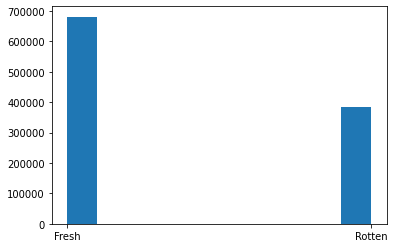

In [ ]:
plt.hist(df['review_type'])

## Cleaning text

In [ ]:
# combining all reviews into one text
all_reviews = " ".join(df["review_content"])

In [ ]:
# printing part of all_reviews
all_reviews[:3000]

'A fantasy adventure that fuses Greek mythology to contemporary American places and values. Anyone around 15 (give or take a couple of years) will thrill to the visual spectacle Uma Thurman as Medusa, the gorgon with a coiffure of writhing snakes and stone-inducing hypnotic gaze is one of the highlights of this bewitching fantasy With a top-notch cast and dazzling special effects, this will tide the teens over until the next Harry Potter instalment. Whether audiences will get behind The Lightning Thief is hard to predict. Overall, it\'s an entertaining introduction to a promising new world -- but will the consuming shadow of Potter be too big to break free of? What\'s really lacking in The Lightning Thief is a genuine sense of wonder, the same thing that brings viewers back to Hogwarts over and over again. It\'s more a list of ingredients than a movie-magic potion to enjoy from start to finish. Harry Potter knockoffs don\'t come more transparent and slapdash than this wannabe-franchise

### Checking the vocabulary

In [ ]:
chars = sorted(list(set(all_reviews))) 
vocab_size = len(chars) 
print(''.join(chars)) 
print(vocab_size)

 !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~ ©·ÀÁÂÃÅÈÉÊÍÓÔÕÖØÚÜÞßàáâãäåæçèéêëìíîïðñòóôõöøùúûüýāăćčłńōřśŞşūŻȏșț́̃̇̈̊ΑΟάέήίαβγδεηθικλμνοπρςστυφχωόώӓᴱᴵᴸᵀ    ​‍‎‐‑‒–—―‘’“”…  ‪‬′″⁠₂™−∙≤≥─●★♥ツﬁ﻿💰
249


In [ ]:
def cleaning_text(text):
  text = text.lower() 
  text = re.sub(' 😤 ', "", text) 
  text = re.sub('\[.*?\]', '', text) 
  text = re.sub('https?://\S+|www\.\S+', '', text) 
  text = re.sub('<.*?>+', '', text) 
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text) 
  text = re.sub('[‘’“”…]', '', text) 
  return text 
cleaning = lambda x: cleaning_text(x)

In [ ]:
df_new = df.copy()
df_new['clean_reviews'] = df_new['review_content'].apply(cleaning)
df_new.head()

,top_critic,review_type,review_content,clean_reviews
0,False,Fresh,A fantasy adventure that fuses Greek mythology...,a fantasy adventure that fuses greek mythology...
1,False,Fresh,"Uma Thurman as Medusa, the gorgon with a coiff...",uma thurman as medusa the gorgon with a coiffu...
2,False,Fresh,With a top-notch cast and dazzling special eff...,with a topnotch cast and dazzling special effe...
3,False,Fresh,Whether audiences will get behind The Lightnin...,whether audiences will get behind the lightnin...
4,True,Rotten,What's really lacking in The Lightning Thief i...,whats really lacking in the lightning thief is...


In [ ]:
all_clean_reviews = " ".join(df_new['clean_reviews'])
chars = sorted(list(set(all_clean_reviews))) 
vocab_size = len(chars) 
print(''.join(chars)) 
print(vocab_size)

 0123456789abcdefghijklmnopqrstuvwxyz ©·ßàáâãäåæçèéêëìíîïðñòóôõöøùúûüýþāăćčłńōřśşūżșț́̃̇̈̊άέήίαβγδεηθικλμνοπρςστυφχωόώӓᴱᴵᴸᵀ    ​‍‎‐‑‒–—―  ‪‬′″⁠₂™−∙≤≥─●★♥ツﬁ﻿💰
166


In [ ]:
df_new[df_new['clean_reviews'] == '']

,top_critic,review_type,review_content,clean_reviews
60688,False,Rotten,.,
91667,False,Fresh,.,
125894,False,Fresh,http://cinefantastiqueonline.com/2008/09/16/fi...,
136533,False,Rotten,.,
158117,False,Fresh,.,
207302,False,Fresh,[Full Review in Greek],
211549,False,Rotten,.,
212058,False,Rotten,.,
222343,False,Fresh,http://www.spiritualityandpractice.com/films/r...,
241057,False,Fresh,.,


In [ ]:
df_new = df_new[df_new['clean_reviews'] != '']
df_new.shape

(1064154, 4)

In [ ]:
# checking the stopwords

from nltk.corpus import stopwords
stop = stopwords.words('english')
stop

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
df_new['clean_reviews'] = df_new['clean_reviews'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df_new

,top_critic,review_type,review_content,clean_reviews
0,False,Fresh,A fantasy adventure that fuses Greek mythology...,fantasy adventure fuses greek mythology contem...
1,False,Fresh,"Uma Thurman as Medusa, the gorgon with a coiff...",uma thurman medusa gorgon coiffure writhing sn...
2,False,Fresh,With a top-notch cast and dazzling special eff...,topnotch cast dazzling special effects tide te...
3,False,Fresh,Whether audiences will get behind The Lightnin...,whether audiences get behind lightning thief h...
4,True,Rotten,What's really lacking in The Lightning Thief i...,whats really lacking lightning thief genuine s...
...,...,...,...,...
1130008,False,Fresh,A rousing reconstruction of the 1879 Battle of...,rousing reconstruction 1879 battle rorkes drift
1130013,False,Fresh,"Seen today, it's not only a startling indictme...",seen today startling indictment british imperi...
1130014,False,Fresh,A rousing visual spectacle that's a prequel of...,rousing visual spectacle thats prequel cy endf...
1130015,False,Rotten,"A simple two-act story: Prelude to war, and th...",simple twoact story prelude war war former con...


In [ ]:
# removing punctuation
df_new['clean_reviews'][:10].apply(lambda x: str(TextBlob(x).correct()))

0    fantasy adventure fuses greek mythology contem...
1    ma human medulla gordon coiffure writhing snak...
2    topnotch cast dazzling special effects tide te...
3    whether audiences get behind lightning thief h...
4    what really lacking lightning thief genuine se...
5    list ingredient moviemagic portion enjoy start...
6    harry porter knockoffs dont come transparent s...
7    percy jackson isn great movie good one trottin...
8                                fun brisk imaginative
9    crammed dragoons setdestroying fights things e...
Name: clean_reviews, dtype: object

In [ ]:
df_new

,top_critic,review_type,review_content,clean_reviews
0,False,Fresh,A fantasy adventure that fuses Greek mythology...,fantasy adventure fuses greek mythology contem...
1,False,Fresh,"Uma Thurman as Medusa, the gorgon with a coiff...",uma thurman medusa gorgon coiffure writhing sn...
2,False,Fresh,With a top-notch cast and dazzling special eff...,topnotch cast dazzling special effects tide te...
3,False,Fresh,Whether audiences will get behind The Lightnin...,whether audiences get behind lightning thief h...
4,True,Rotten,What's really lacking in The Lightning Thief i...,whats really lacking lightning thief genuine s...
...,...,...,...,...
1130008,False,Fresh,A rousing reconstruction of the 1879 Battle of...,rousing reconstruction 1879 battle rorkes drift
1130013,False,Fresh,"Seen today, it's not only a startling indictme...",seen today startling indictment british imperi...
1130014,False,Fresh,A rousing visual spectacle that's a prequel of...,rousing visual spectacle thats prequel cy endf...
1130015,False,Rotten,"A simple two-act story: Prelude to war, and th...",simple twoact story prelude war war former con...


In [ ]:
df_new.drop_duplicates(inplace = True)
df_new.shape

(949669, 4)

## Sentiment Analysis

In [ ]:
def fetch_sentiment_using_textblob(text):
  analysis = TextBlob(text)
  return 'positive' if analysis.sentiment.polarity >= 0 else 'negative'

In [ ]:
fetch_sentiment_using_textblob = df_new['clean_reviews'].apply(lambda x: fetch_sentiment_using_textblob(x))
pd.DataFrame(fetch_sentiment_using_textblob.value_counts())

,clean_reviews
positive,715350
negative,234319


In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
sid = SentimentIntensityAnalyzer()
sid.polarity_scores(df_new['clean_reviews'][4])

{'neg': 0.234, 'neu': 0.766, 'pos': 0.0, 'compound': -0.5667}

In [ ]:
df_new['review_type'][4]

'Rotten'

In [ ]:
df_score = pd.DataFrame()
df_score['clean_reviews'] = df_new['clean_reviews']
df_score['scores'] = df_score['clean_reviews'].apply(lambda review: sid.polarity_scores(review))
df_score['compound'] = df_score['scores'].apply(lambda scores: scores['compound'])
df_score['sentiment'] = df_score['compound'].apply(lambda c: 'Positive' if c >=0 else 'Negative')

In [ ]:
df_score['true_label'] = df_new['review_type']
df_score

,clean_reviews,scores,compound,sentiment,true_label
0,fantasy adventure fuses greek mythology contem...,"{'neg': 0.0, 'neu': 0.681, 'pos': 0.319, 'comp...",0.7579,Positive,Fresh
1,uma thurman medusa gorgon coiffure writhing sn...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0,Positive,Fresh
2,topnotch cast dazzling special effects tide te...,"{'neg': 0.0, 'neu': 0.787, 'pos': 0.213, 'comp...",0.4019,Positive,Fresh
3,whether audiences get behind lightning thief h...,"{'neg': 0.167, 'neu': 0.523, 'pos': 0.31, 'com...",0.6249,Positive,Fresh
4,whats really lacking lightning thief genuine s...,"{'neg': 0.234, 'neu': 0.766, 'pos': 0.0, 'comp...",-0.5667,Negative,Rotten
...,...,...,...,...,...
1130008,rousing reconstruction 1879 battle rorkes drift,"{'neg': 0.342, 'neu': 0.658, 'pos': 0.0, 'comp...",-0.3818,Negative,Fresh
1130013,seen today startling indictment british imperi...,"{'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'comp...",0.0772,Positive,Fresh
1130014,rousing visual spectacle thats prequel cy endf...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0,Positive,Fresh
1130015,simple twoact story prelude war war former con...,"{'neg': 0.324, 'neu': 0.561, 'pos': 0.115, 'co...",-0.8271,Negative,Rotten


(array([694855.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 254814.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

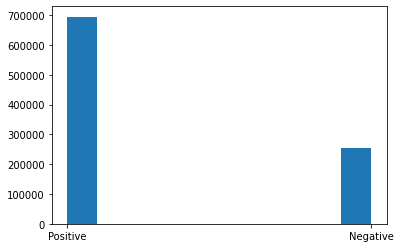

In [ ]:
plt.hist(df_score['sentiment'])

In [ ]:
from wordcloud import WordCloud

In [ ]:
def generate_wordcloud(all_words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100).generate(all_words)     
    plt.figure(figsize=(14, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show

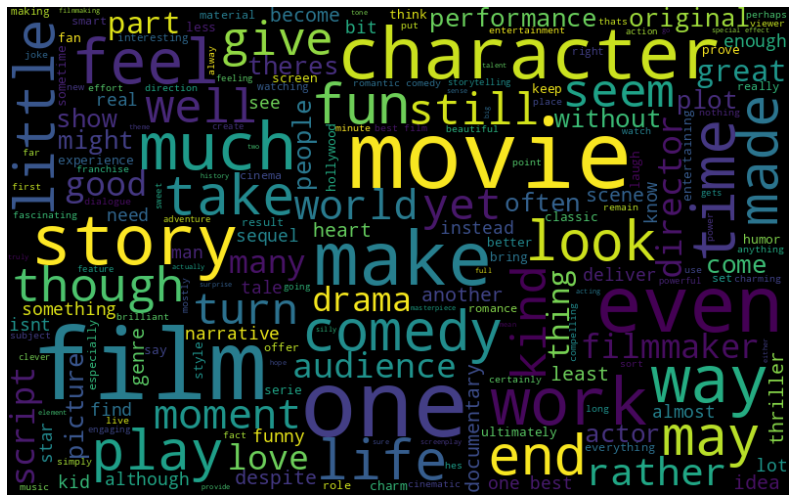

In [ ]:
all_words = ' '.join([text for text in df_score['clean_reviews'][df_score.sentiment == 'Positive']])
generate_wordcloud(all_words)

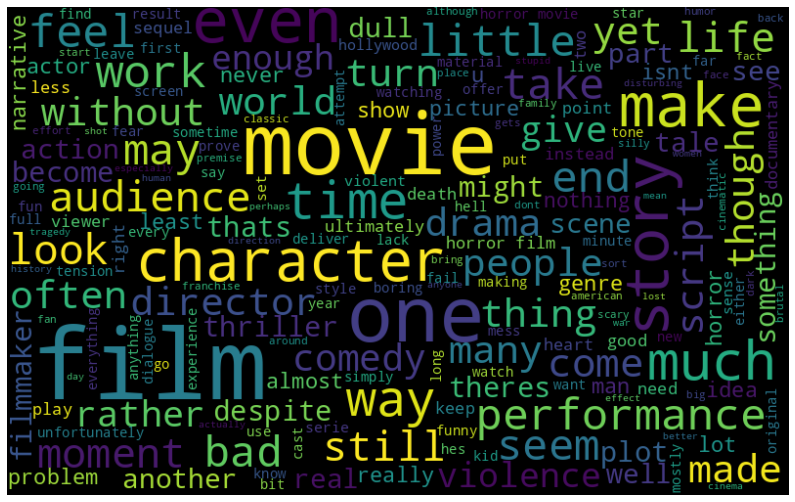

In [ ]:
all_words = ' '.join([text for text in df_score['clean_reviews'][df_score.sentiment == 'Negative']])
generate_wordcloud(all_words)

### Distribution of review sentiment based on top critics (for more reliable results)

In [ ]:
df_score['top_critic'] = df_new['top_critic']
df_score

,clean_reviews,scores,compound,sentiment,true_label,top_critic
0,fantasy adventure fuses greek mythology contem...,"{'neg': 0.0, 'neu': 0.681, 'pos': 0.319, 'comp...",0.7579,Positive,Fresh,False
1,uma thurman medusa gorgon coiffure writhing sn...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0,Positive,Fresh,False
2,topnotch cast dazzling special effects tide te...,"{'neg': 0.0, 'neu': 0.787, 'pos': 0.213, 'comp...",0.4019,Positive,Fresh,False
3,whether audiences get behind lightning thief h...,"{'neg': 0.167, 'neu': 0.523, 'pos': 0.31, 'com...",0.6249,Positive,Fresh,False
4,whats really lacking lightning thief genuine s...,"{'neg': 0.234, 'neu': 0.766, 'pos': 0.0, 'comp...",-0.5667,Negative,Rotten,True
...,...,...,...,...,...,...
1130008,rousing reconstruction 1879 battle rorkes drift,"{'neg': 0.342, 'neu': 0.658, 'pos': 0.0, 'comp...",-0.3818,Negative,Fresh,False
1130013,seen today startling indictment british imperi...,"{'neg': 0.0, 'neu': 0.874, 'pos': 0.126, 'comp...",0.0772,Positive,Fresh,False
1130014,rousing visual spectacle thats prequel cy endf...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0,Positive,Fresh,False
1130015,simple twoact story prelude war war former con...,"{'neg': 0.324, 'neu': 0.561, 'pos': 0.115, 'co...",-0.8271,Negative,Rotten,False


(array([ 68889.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 182065.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

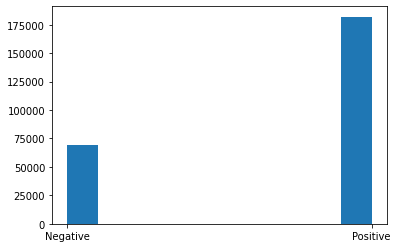

In [ ]:
plt.hist(df_score[df_score['top_critic']==True]['sentiment'])

(array([512790.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 185925.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

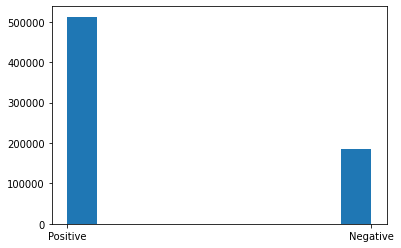

In [ ]:
plt.hist(df_score[df_score['top_critic']==False]['sentiment'])

In [ ]:
encoded_labels = {"sentiment":     {"Positive": 1, "Negative": 0},
                "true_label": {"Fresh": 1, "Rotten": 0}}
df_score = df_score.replace(encoded_labels)
df_score.head()

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(df_score['sentiment'].values, df_score['true_label'].values)
print("The accuracy is:", accuracy)

The accuracy is: 0.6476667133495987


##Evaluation

**Strategy 1**: Following this path we created two balanced datasets to tackle two different problems:
- prediction of the type of the review (classification).
- prediction of the score of the review (regression).

Both the tasks were approached working on top of a pretrained BERT model,
stacking some layers upon it:
- in the case of classification, the last layer is a linear layer with two neurons as output, that is, the two probabilities that the review is either 
- in the case of regression, the last layer is a linear layer with one neuron as output (the actual predicted score, a number between 0 and 1 that will
be rescaled accordingly),
- in both cases a dropout layer was added just after the pre-trained BERT model output, and an additional linear hidden layer was added.

Accuracy: Classification + Bert = 81 %

*It might be interesting to see how the Bert model would perform on the entire dataset, or even on a larger segment of the data.*



**Strategy 2**: In this approach, we used a simple method (SentimentIntensityAnalyzer) to analyze the sentiment behind the review. The SentimentIntensityAnalyzer gives the results in a format of multiple scores: negative, neutral, positive, and compound. After getting the scores of all the reviews, we labeled the prediction with positive and egative based on the compound score (a score lower than 0 is negative and a score greater or equal to 0 is positive). 
Next, to be able to visualize what the algorithm did, we plotted the word cloud of the positive and negative vocabulary.
We also calculated the accuracy score by comparing the predicted sentiment with the true label (positive = fresh, and negative = rotten) 
Lastly, to be able to implement such approach in a real-life scenario we seperately showed the reviews of the top critics and normal critics. This approach can be used to accurately and reliably rate movies based on reviews from true top critics

Accuracy: Classification + Sentiment Analysis = 64.7%

#Conclusion:
##What Worked:



*   Balancing the training data
*   Selection of Important features from the dataset
* Using Bert model did improve the performnace of the model.
*   The approach with considering only the review type showed better results than the other.

##Limitations:



*   Preprocessing might have led to overfitting the model
*   Could not test the first approach on a bigger dataset or the entire dataset




##What could have been done better



*   feature engineering to improve the accuracy of sentiment classification. For example, features like word count, sentence length, and punctuation count could be used.


*  providing pre-defined lists of words and phrases that are associated with positive and negative sentiment in the context of movie reviews to improve sentiment classification accuracy













